In [8]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Veri setini yükleyelim
df = pd.read_csv('dataset.csv')

# 'datetime' sütununu tarih-zaman formatına çevirelim
df['datetime'] = pd.to_datetime(df['datetime'])

# 'datetime' sütununu index olarak ayarlayalım
df.set_index('datetime', inplace=True)

# Sadece su seviyesi ('stage_m') sütununu alalım
df_univariate = df[['stage_m']].copy()

# Olası eksik verileri kontrol edelim ve dolduralım
# Zaman serilerinde 'linear' (doğrusal) enterpolasyon yaygın bir yöntemdir
df_univariate['stage_m'].interpolate(method='linear', inplace=True)

print("Veri setinin ilk 5 satırı:")
print(df_univariate.head())
print("\nEksik veri kontrolü (varsa 0 olmalı):", df_univariate.isnull().sum())

Veri setinin ilk 5 satırı:
                           stage_m
datetime                          
1995-10-01 00:00:00+00:00     1.96
1995-10-02 00:00:00+00:00     1.93
1995-10-03 00:00:00+00:00     1.91
1995-10-04 00:00:00+00:00     3.79
1995-10-05 00:00:00+00:00     5.41

Eksik veri kontrolü (varsa 0 olmalı): stage_m    0
dtype: int64


/tmp/ipykernel_47173/2044954732.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_univariate['stage_m'].interpolate(method='linear', inplace=True)


Eğitim verisi boyutu: 8493
Validasyon verisi boyutu: 2359


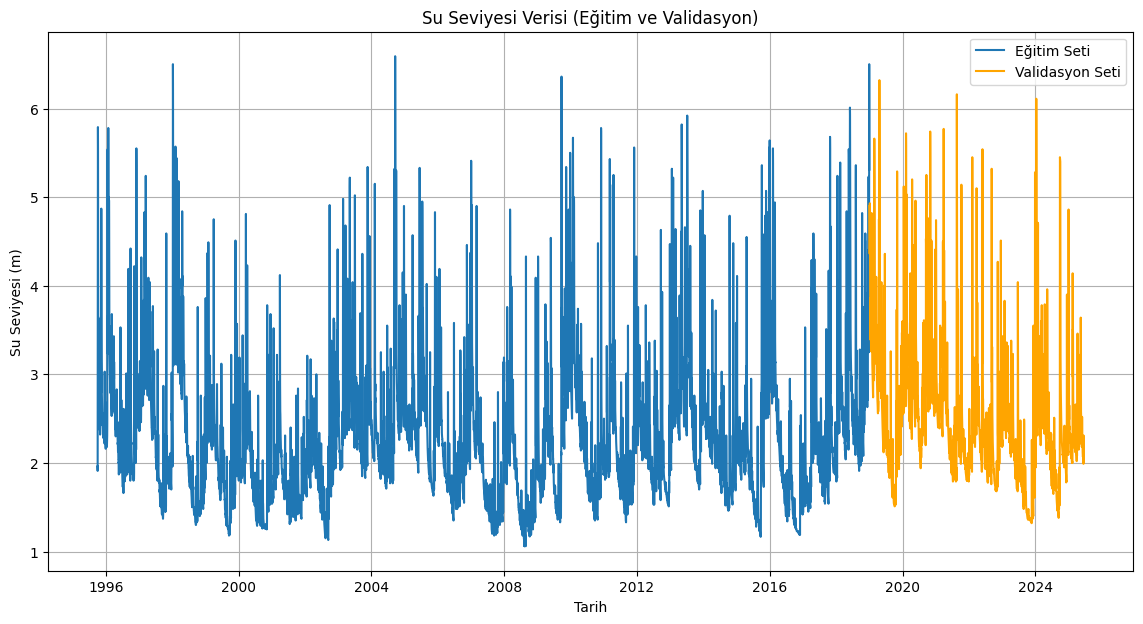

In [9]:
# Veriyi ayırmak için bir tarih belirleyelim
split_date = '2019-01-01'

# Veriyi eğitim ve validasyon olarak ayıralım
train_data = df_univariate.loc[df_univariate.index < split_date]
val_data = df_univariate.loc[df_univariate.index >= split_date]

print(f"Eğitim verisi boyutu: {len(train_data)}")
print(f"Validasyon verisi boyutu: {len(val_data)}")

# Veriyi görselleştirelim
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['stage_m'], label='Eğitim Seti')
plt.plot(val_data.index, val_data['stage_m'], label='Validasyon Seti', color='orange')
plt.title('Su Seviyesi Verisi (Eğitim ve Validasyon)')
plt.xlabel('Tarih')
plt.ylabel('Su Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Ölçekleyiciyi oluşturalım
scaler = StandardScaler()

# Ölçekleyiciyi SADECE eğitim verisine göre ayarlayalım ve dönüştürelim
scaled_train_data = scaler.fit_transform(train_data)

# Eğitim verisine göre ayarlanmış ölçekleyiciyi validasyon verisine uygulayalım
scaled_val_data = scaler.transform(val_data)

# Dönüştürülmüş verileri tekrar DataFrame'e çevirelim (isteğe bağlı ama kullanışlı)
scaled_train_df = pd.DataFrame(scaled_train_data, index=train_data.index, columns=['stage_m'])
scaled_val_df = pd.DataFrame(scaled_val_data, index=val_data.index, columns=['stage_m'])

print("\nÖlçeklendirilmiş Eğitim Verisi (ilk 5 satır):")
print(scaled_train_df.head())


Ölçeklendirilmiş Eğitim Verisi (ilk 5 satır):
                            stage_m
datetime                           
1995-10-01 00:00:00+00:00 -0.382791
1995-10-02 00:00:00+00:00 -0.421798
1995-10-03 00:00:00+00:00 -0.447803
1995-10-04 00:00:00+00:00  1.996619
1995-10-05 00:00:00+00:00  4.102981


In [11]:
def create_sequences(data, n_past, n_future):
    """
    Zaman serisi verisinden girdi (X) ve çıktı (y) dizileri oluşturur.
    
    :param data: Zaman serisi verisi (numpy array).
    :param n_past: Girdi olarak kullanılacak geçmiş zaman adımı sayısı.
    :param n_future: Tahmin edilecek gelecek zaman adımı sayısı.
    :return: Girdi (X) ve çıktı (y) dizileri.
    """
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, 0:data.shape[1]])
        y.append(data[i + n_future - 1:i + n_future, 0])
    return np.array(X), np.array(y)

# Geçmiş kaç günü kullanarak tahmin yapacağımızı belirleyelim
# Örneğin, son 7 günü kullanarak bir sonraki günü tahmin edelim
N_PAST = 7
N_FUTURE = 1

# Eğitim verisi için dizileri oluşturalım
X_train, y_train = create_sequences(scaled_train_data, N_PAST, N_FUTURE)

# Validasyon verisi için dizileri oluşturalım
X_val, y_val = create_sequences(scaled_val_data, N_PAST, N_FUTURE)

print(f"\nOluşturulan dizi şekilleri:")
print(f"X_train şekli: {X_train.shape}") # (örnek_sayısı, geçmiş_gün_sayısı, özellik_sayısı)
print(f"y_train şekli: {y_train.shape}")   # (örnek_sayısı, 1)
print(f"X_val şekli: {X_val.shape}")
print(f"y_val şekli: {y_val.shape}")


Oluşturulan dizi şekilleri:
X_train şekli: (8486, 7, 1)
y_train şekli: (8486, 1)
X_val şekli: (2352, 7, 1)
y_val şekli: (2352, 1)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Baseline tahminleri oluşturuyoruz: y_val'in bir gün önceki değeri
# X_val'deki her dizinin son değeri, tahminin yapılacağı 'bugünün' değeridir.
baseline_predictions_scaled = X_val[:, -1, 0]

# Gerçek değerler
y_true_scaled = y_val.flatten()

# Performans metriklerini ölçeklenmiş veri üzerinde hesaplayalım
mae_baseline_scaled = mean_absolute_error(y_true_scaled, baseline_predictions_scaled)
rmse_baseline_scaled = np.sqrt(mean_squared_error(y_true_scaled, baseline_predictions_scaled))

# Metrikleri orijinal ölçeğe (metre) dönüştürmek daha anlamlıdır.
# Bunun için hem tahminleri hem de gerçek değerleri geri dönüştürmeliyiz.
y_true_original = scaler.inverse_transform(y_val)
baseline_predictions_original = scaler.inverse_transform(baseline_predictions_scaled.reshape(-1, 1))

mae_baseline = mean_absolute_error(y_true_original, baseline_predictions_original)
rmse_baseline = np.sqrt(mean_squared_error(y_true_original, baseline_predictions_original))
r2_baseline = r2_score(y_true_original, baseline_predictions_original)

print("--- Baseline Model Performansı (Orijinal Ölçek - Metre) ---")
print(f"Ortalama Mutlak Hata (MAE): {mae_baseline:.4f} m")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_baseline:.4f} m")
print(f"R-Kare (R²): {r2_baseline:.4f}")

--- Baseline Model Performansı (Orijinal Ölçek - Metre) ---
Ortalama Mutlak Hata (MAE): 0.1796 m
Kök Ortalama Kare Hata (RMSE): 0.3591 m
R-Kare (R²): 0.7749


In [13]:
# Gerekli TensorFlow ve Keras kütüphanelerini import edelim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# --- HİPERPARAMETRE OPTİMİZASYONUNDAN ELDE EDİLEN EN İYİ PARAMETRELER ---
# Bu değerleri kendi optimizasyon sonuçlarınla değiştirmelisin.
BEST_UNITS = 128
BEST_DROPOUT_RATE = 0.2
BEST_LEARNING_RATE = 0.001
BEST_BATCH_SIZE = 64
# --------------------------------------------------------------------

# 1. Modeli EN İYİ parametrelerle yeniden oluşturalım
final_model = Sequential([
    LSTM(units=BEST_UNITS, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(rate=BEST_DROPOUT_RATE),
    Dense(units=1)
])

# 2. Modeli EN İYİ öğrenme oranı ile derleyelim
optimizer = tf.keras.optimizers.Adam(learning_rate=BEST_LEARNING_RATE)
final_model.compile(optimizer=optimizer, loss='mean_squared_error')

final_model.summary()

# 3. Callbacks (Geri Aramalar) Tanımlayalım
# EarlyStopping: 'val_loss' 10 epoch boyunca iyileşmezse eğitimi durdur.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True # Eğitimi durdurduğunda en iyi ağırlıklara geri döner.
)

# ModelCheckpoint: Eğitim boyunca en iyi modeli 'best_univariate_model.keras' adıyla kaydet.
model_checkpoint = ModelCheckpoint(
    filepath='best_univariate_model.keras', 
    save_best_only=True, 
    monitor='val_loss',
    mode='min' # 'val_loss'u minimize etmeye çalıştığımız için 'min'
)


# 4. Modeli Callbacks ile Eğitelim
# Epoch sayısını yüksek bir değere ayarlayabiliriz (örneğin 200), EarlyStopping en uygun yerde durduracaktır.
history = final_model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    batch_size=BEST_BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint], # Callbacks listesi
    verbose=1
)

/home/yasirgunes/bitirme/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-06-17 18:52:59.830982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 680 bytes spill stores, 548 bytes spill loads

2025-06-17 18:52:59.894227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 4 bytes spill stores, 4 bytes spill loads



124/133 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4875

2025-06-17 18:53:03.409850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 124 bytes spill stores, 124 bytes spill loads

2025-06-17 18:53:03.431390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 68 bytes spill stores, 68 bytes spill loads

2025-06-17 18:53:03.652204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 544 bytes spill stores, 544 bytes spill loads

2025-06-17 18:53:03.865323: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 4 bytes spill stores, 4 bytes spill loads



133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.4791 - val_loss: 0.2777
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2472 - val_loss: 0.2249
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2257 - val_loss: 0.1947
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2060 - val_loss: 0.1872
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1903 - val_loss: 0.1876
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1738 - val_loss: 0.1803
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1870 - val_loss: 0.1747
Epoch 8/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1833 - val_loss: 0.1733
Epoch 9/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1670 - val_loss: 0.1739
Epoch 10/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1651 - val_loss: 0.1732
Epoch 11/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1804 - val_loss: 0.1764
Epoch 12/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/st

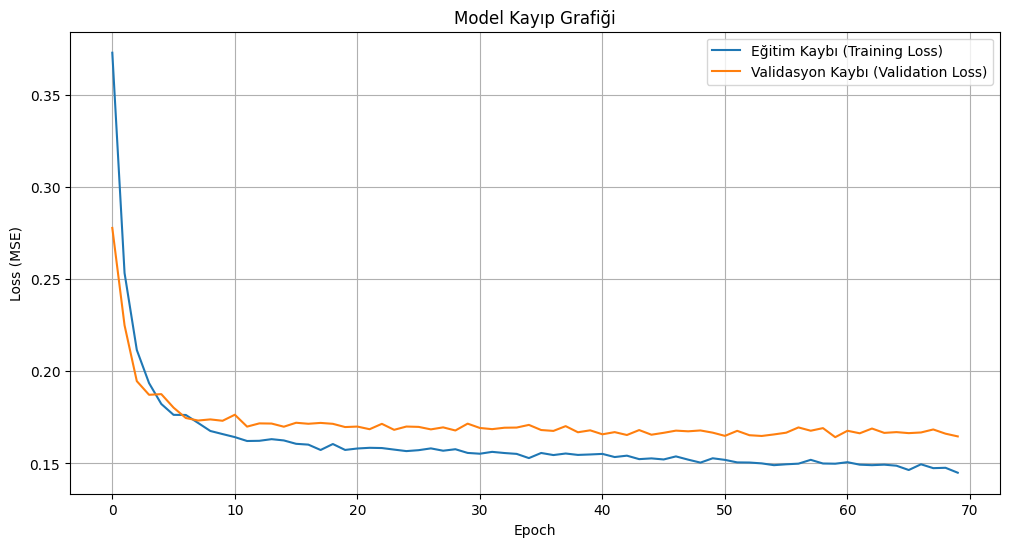

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- LSTM Model Performansı (Orijinal Ölçek - Metre) ---
Ortalama Mutlak Hata (MAE): 0.1563 m
Kök Ortalama Kare Hata (RMSE): 0.3119 m
R-Kare (R²): 0.8302


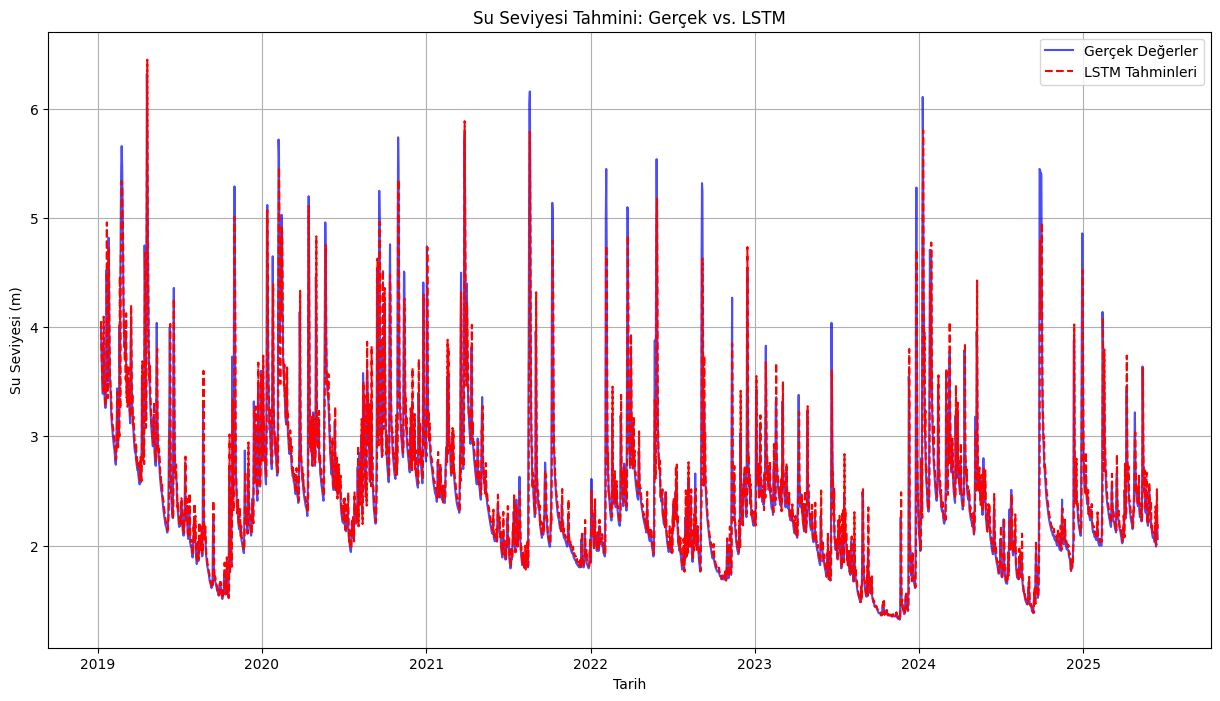

In [14]:
# Eğitim ve validasyon kayıp (loss) grafiğini çizdirelim
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı (Training Loss)')
plt.plot(history.history['val_loss'], label='Validasyon Kaybı (Validation Loss)')
plt.title('Model Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 1. Validasyon seti üzerinde tahmin yap
predictions_scaled = model.predict(X_val)

# 2. Tahminleri ve gerçek değerleri orijinal ölçeğe geri dönüştür
y_true_original = scaler.inverse_transform(y_val)
predictions_original = scaler.inverse_transform(predictions_scaled)

# 3. Performans metriklerini hesapla
mae_lstm = mean_absolute_error(y_true_original, predictions_original)
rmse_lstm = np.sqrt(mean_squared_error(y_true_original, predictions_original))
r2_lstm = r2_score(y_true_original, predictions_original)

print("\n--- LSTM Model Performansı (Orijinal Ölçek - Metre) ---")
print(f"Ortalama Mutlak Hata (MAE): {mae_lstm:.4f} m")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_lstm:.4f} m")
print(f"R-Kare (R²): {r2_lstm:.4f}")

# 4. Sonuçları görselleştir
plt.figure(figsize=(15, 8))
# Validasyon setinin tarihlerini almalıyız
val_dates = val_data.index[N_PAST:] # Sequence oluştururken kaybettiğimiz ilk N_PAST günü atlıyoruz

plt.plot(val_dates, y_true_original.flatten(), label='Gerçek Değerler', color='blue', alpha=0.7)
plt.plot(val_dates, predictions_original.flatten(), label='LSTM Tahminleri', color='red', linestyle='--')
plt.title('Su Seviyesi Tahmini: Gerçek vs. LSTM')
plt.xlabel('Tarih')
plt.ylabel('Su Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.show()


Eğitim boyunca kaydedilen en iyi model yükleniyor...
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

--- Optimize Edilmiş ve Kaydedilmiş Final Model Performansı ---
Ortalama Mutlak Hata (MAE): 0.1650 m
Kök Ortalama Kare Hata (RMSE): 0.3117 m
R-Kare (R²): 0.8304


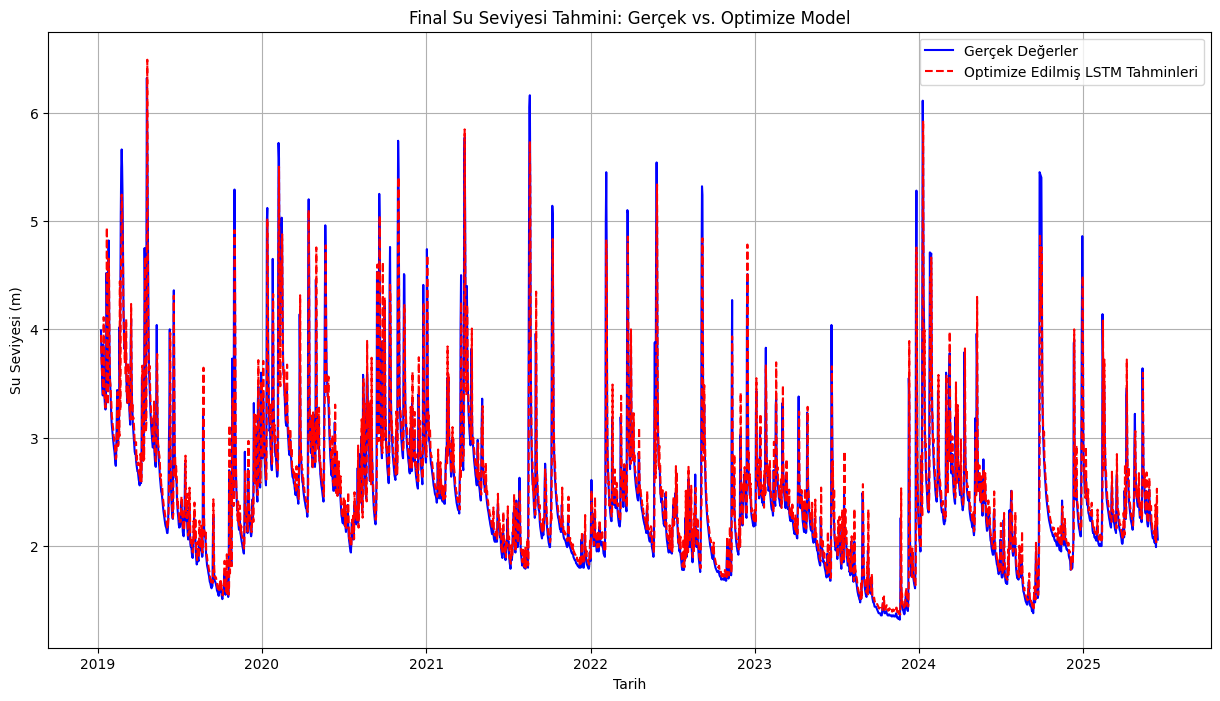

In [15]:
# Kaydedilen en iyi modeli yükleyelim
print("\nEğitim boyunca kaydedilen en iyi model yükleniyor...")
saved_best_model = load_model('best_univariate_model.keras')

# Yüklenen model ile tahmin yapalım
predictions_scaled = saved_best_model.predict(X_val)

# Tahminleri orijinal ölçeğe dönüştürelim
y_true_original = scaler.inverse_transform(y_val)
predictions_original = scaler.inverse_transform(predictions_scaled)

# Performans metriklerini hesaplayalım
mae_final = mean_absolute_error(y_true_original, predictions_original)
rmse_final = np.sqrt(mean_squared_error(y_true_original, predictions_original))
r2_final = r2_score(y_true_original, predictions_original)

print("\n--- Optimize Edilmiş ve Kaydedilmiş Final Model Performansı ---")
print(f"Ortalama Mutlak Hata (MAE): {mae_final:.4f} m")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_final:.4f} m")
print(f"R-Kare (R²): {r2_final:.4f}")

# Sonuçları görselleştirelim
plt.figure(figsize=(15, 8))
val_dates = val_data.index[N_PAST:]
plt.plot(val_dates, y_true_original.flatten(), label='Gerçek Değerler', color='blue')
plt.plot(val_dates, predictions_original.flatten(), label='Optimize Edilmiş LSTM Tahminleri', color='red', linestyle='--')
plt.title('Final Su Seviyesi Tahmini: Gerçek vs. Optimize Model')
plt.xlabel('Tarih')
plt.ylabel('Su Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.show()